# AISC2007 DL Assignment2 Group 5

#### Importing Necessary Libraries

In [14]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix


In [15]:
# Directory containing images
image_folder = "C:/Users/singh/Downloads/yelp_dataset/photos"

In [16]:
#Directory containing imaage metadata
photos_df=pd.read_json("C:/Users/singh/Downloads/yelp_dataset/photos.json", lines=True)

In [17]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [18]:
photos_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [19]:
photos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [20]:
photos_df['label'].isnull().sum()

0

In [21]:
# Count the number of occurrences of each label
label_counts = photos_df['label'].value_counts()
label_counts

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [22]:
# Sort the counts in descending order (high to low)
sorted_label_counts = label_counts.sort_values(ascending=False)

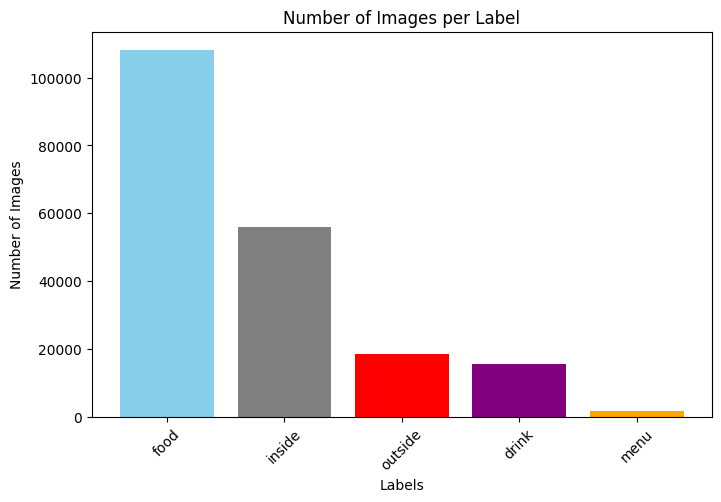

In [23]:
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(sorted_label_counts.index, sorted_label_counts.values, color=['skyblue', 'grey', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()


In [24]:
def load_images_with_metadata(photo_df, image_folder, max_images_per_label=1678):
    images, labels = [], []
    label_counts = {}  # Dictionary to keep track of loaded images per label

    for index, row in photo_df.iterrows():
        photo_id = row['photo_id']
        label = row['label']

        # Initialize count for the label if it hasn't been already
        if label not in label_counts:
            label_counts[label] = 0

        # Check if the limit has been reached for this label
        if label_counts[label] >= max_images_per_label:
            continue  # Skip loading images for this label if limit is reached

        img_path = os.path.join(image_folder, f"{photo_id}.jpg")  # Adjust extension if needed

        try:
            # Load the image
            img = load_img(img_path, target_size=(128, 128))  # Adjust target size if needed
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            
            # Append the image and its corresponding label
            images.append(img_array)
            labels.append(label)

            # Increment the count for this label
            label_counts[label] += 1

        except FileNotFoundError:
            print(f"Image {img_path} not found.")
        except UnidentifiedImageError:
            print(f"Skipping {img_path}, not a valid image file.")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [25]:
X, y = load_images_with_metadata(photos_df, image_folder)

# Check the shape of the loaded data
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {len(y)} labels.")


Skipping C:/Users/singh/Downloads/yelp_dataset/photos\ydm3g1wUWSxJnMPgHk2JhQ.jpg, not a valid image file.
Loaded 8390 images with shape (128, 128, 3) and 8390 labels.


# Preprocessing

In [26]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


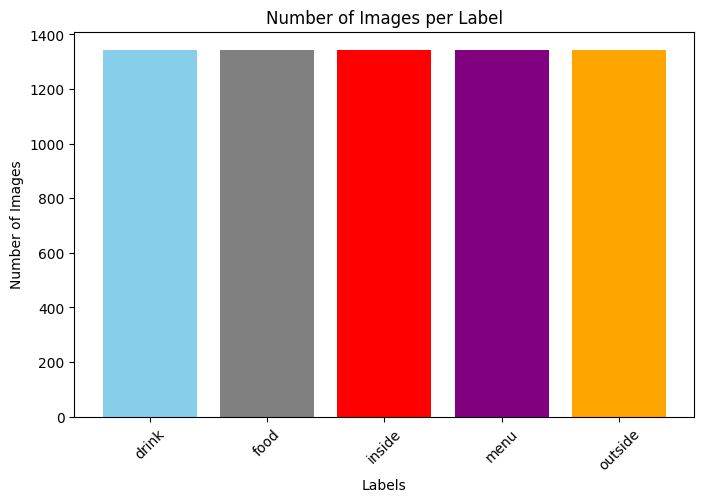

In [27]:
# Count the occurrences of each label
unique, counts = np.unique(y_train, return_counts=True)
sample_label_counts = dict(zip(unique, counts))

# Prepare data for plotting
labels = list(sample_label_counts.keys())
values = list(sample_label_counts.values())

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['skyblue', 'grey', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()


In [28]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_labels(y):
    y_reshaped = y.reshape(-1, 1)  # Reshape for the encoder
    # Initialize OneHotEncoder with sparse_output
    one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
    # Fit and transform the labels
    y_onehot = one_hot_encoder.fit_transform(y_reshaped)
    return y_onehot

# Example usage:
y_train_onehot = one_hot_encode_labels(y_train)
y_test_onehot = one_hot_encode_labels(y_test)


In [29]:
counts=np.unique(y_train, return_counts=True)
counts

(array(['drink', 'food', 'inside', 'menu', 'outside'], dtype='<U7'),
 array([1342, 1343, 1342, 1342, 1343], dtype=int64))

In [30]:
X_train.shape

(6712, 128, 128, 3)

In [31]:
y_train.shape

(6712,)

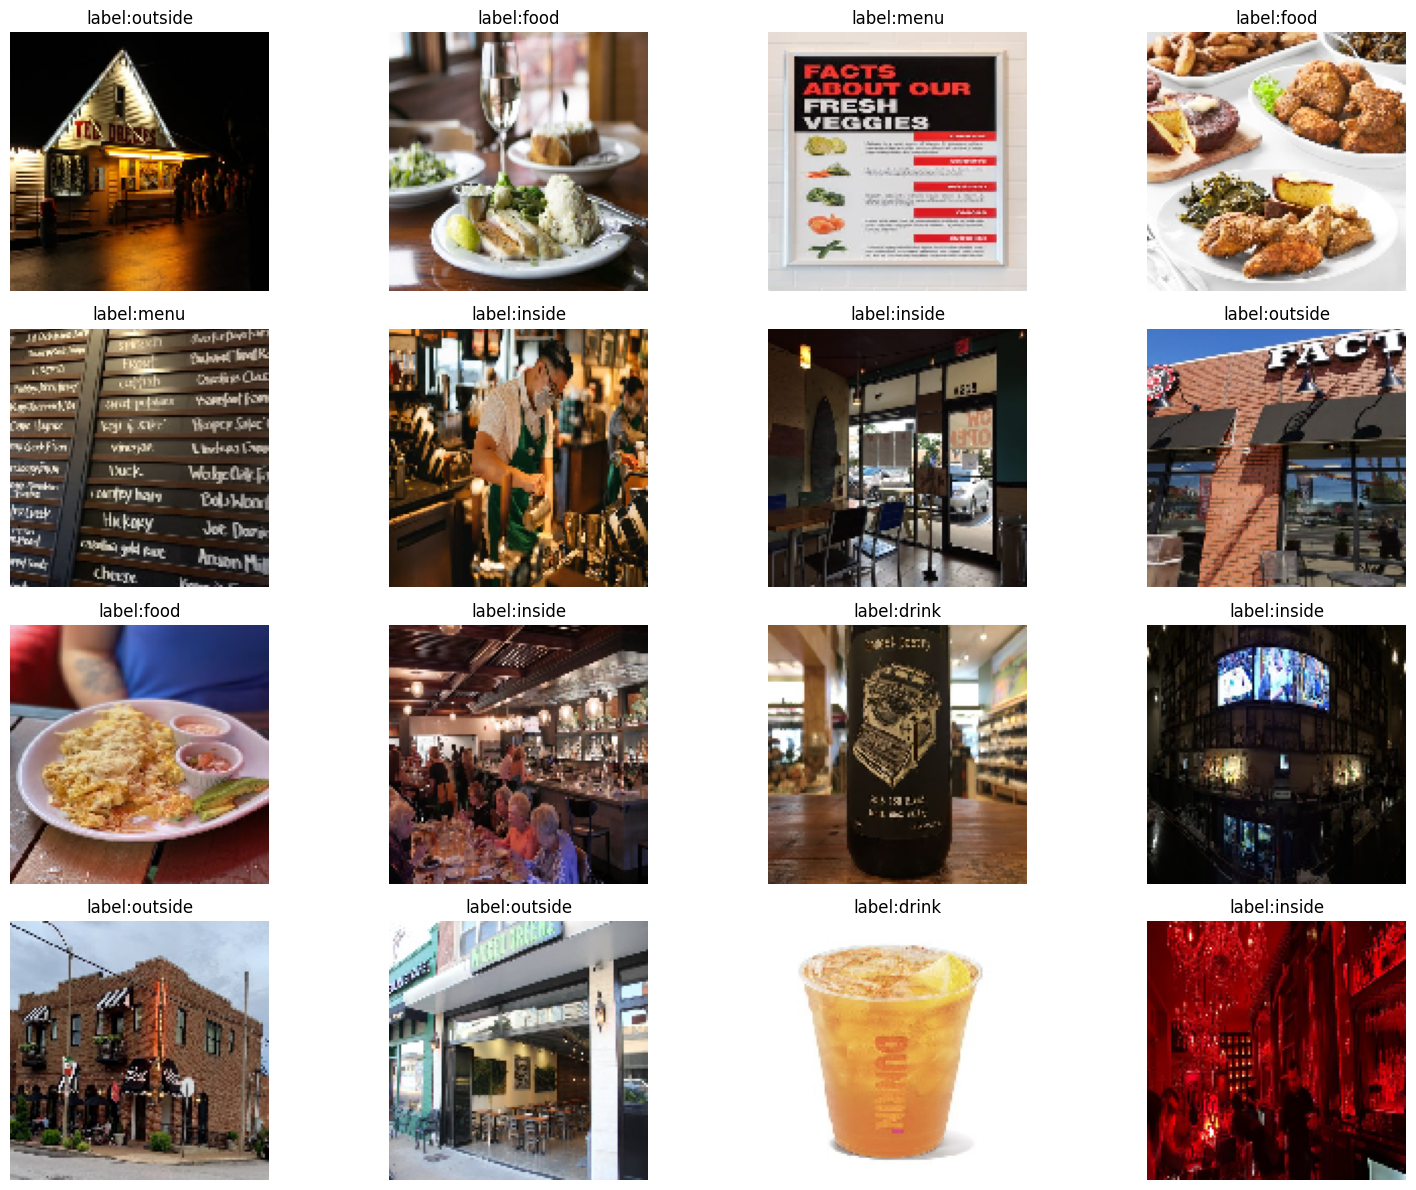

In [32]:
# Set the number of images to display (e.g., 9 images in a 3x3 grid)
num_images = 16
plt.figure(figsize=(16, 12))

# Loop through the number of images and plot each one
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])  # Show the image
    plt.title(f'label:{y_train[i]}')  # Show the class label
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

### CNN Model

Class Balancing (Improved)

In [33]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001  # You can adjust this value

# Create the CNN model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5, activation='softmax'))

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Use categorical_crossentropy if using one-hot encoded labels
              metrics=['accuracy'])

# View the model summary
model.summary()


C:\Users\singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,700,165 (6.49 MB)

 Trainable params: 1,699,717 (6.48 MB)

 Non-trainable params: 448 (1.75 KB)

# Abhijeet Tunning Time 
Improvised Learnig rate

In [35]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [36]:


#Create the CNN model
model = Sequential()

# Define your model architecture
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


In [37]:

# Set learning rate and optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with categorical crossentropy
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
              metrics=['accuracy'])


In [38]:

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Change to .keras
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


## Data augmentation

In [40]:

# Define best parameters
best_params = {
    'batch_size': 32,
    'epochs': 20,
    'dropout_rate': 0.4,
    'optimizer': 'adam'
}


Even After Data augmentation Accuracy is not improving

In [42]:

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_test, y_test_onehot),
    epochs=best_params['epochs'],  
    batch_size=best_params['batch_size'],  
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.4300 - loss: 1.5731 - val_accuracy: 0.2557 - val_loss: 2.7647 - learning_rate: 1.0000e-04
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.5733 - loss: 1.0704 - val_accuracy: 0.4380 - val_loss: 1.9054 - learning_rate: 1.0000e-04
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6375 - loss: 0.9469 - val_accuracy: 0.6758 - val_loss: 0.9198 - learning_rate: 1.0000e-04
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6872 - loss: 0.8116 - val_accuracy: 0.7145 - val_loss: 0.8560 - learning_rate: 1.0000e-04
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.7285 - loss: 0.7090 - val_accuracy: 0.7199 - val_loss: 0.7647 - learning_rate: 1.0000e-04
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.7581 - loss: 0.6208 - val_accuracy: 0.7420 - val_loss: 0.7451 - learning_rate: 1.0000e-04
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 39s 18

In [43]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7599 - loss: 0.7320
Test Loss: 0.7042962908744812, Test Accuracy: 0.7646006941795349


In [44]:
y_predict = model.predict(X_test)
y_predict_classes = tf.argmax(y_predict, axis=1).numpy()  # Get predicted class indices

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [51]:
# Step 2: Convert probabilities to class labels
y_test_true = np.argmax(y_test_onehot, axis=1)  # Convert one-hot to class labels

In [46]:

import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

In [47]:
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1) 

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [52]:
# Print unique values for debugging
print("Unique values in y_test_true:", np.unique(y_test_true))
print("Unique values in y_test_pred_classes:", np.unique(y_test_pred_classes))

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred_classes))

Unique values in y_test_true: [0 1 2 3 4]
Unique values in y_test_pred_classes: [0 1 2 3 4]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       336
           1       0.85      0.81      0.83       335
           2       0.61      0.81      0.69       336
           3       0.89      0.81      0.85       336
           4       0.80      0.70      0.74       335

    accuracy                           0.76      1678
   macro avg       0.78      0.76      0.77      1678
weighted avg       0.78      0.76      0.77      1678



## Tunning 


1. Accuracy Increasing By epoch Number till 20 lets see if we increase more . can it improve it more Last Checkpoint 20 epoch =75% accuracy
2. learning Rate is best when 0.0001 after thisit starts decreasing the accuracy

##### Lets try other available methods

# Graphs

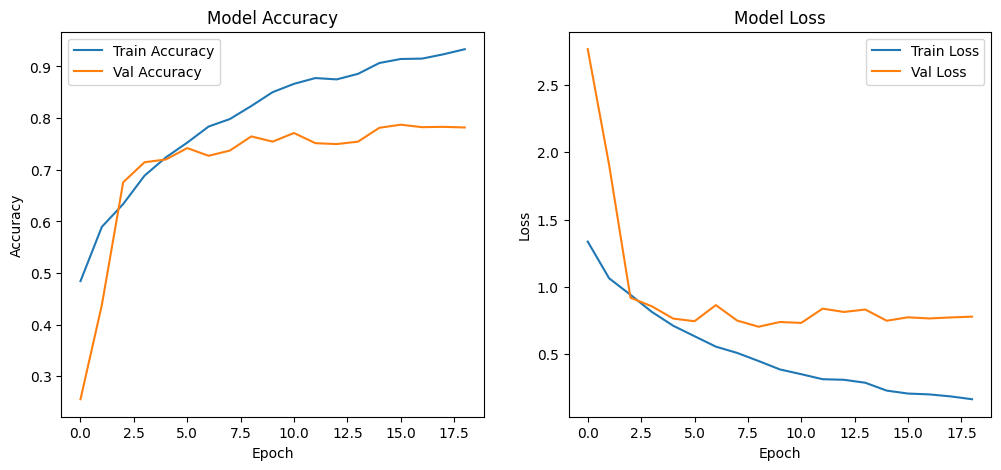

In [53]:
# Assuming `history` is the output of your model.fit() call
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


#### Confusion matrix 

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc



In [56]:
# Predictions for the training set
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Predictions for the test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# True classes for both sets
y_train_true = np.argmax(y_train_onehot, axis=1)
y_test_true = np.argmax(y_test_onehot, axis=1)


210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [57]:
# Confusion Matrix for Training Set
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test_true, y_test_pred_classes)


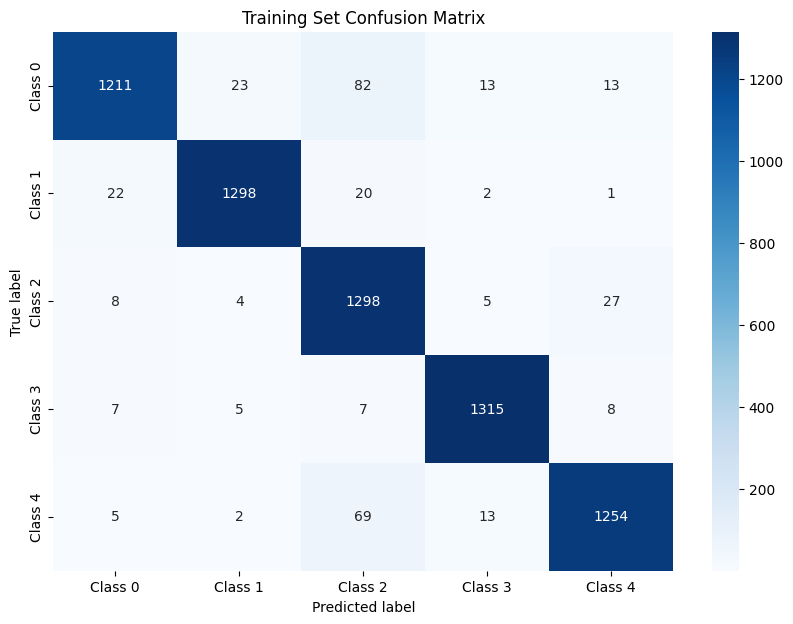

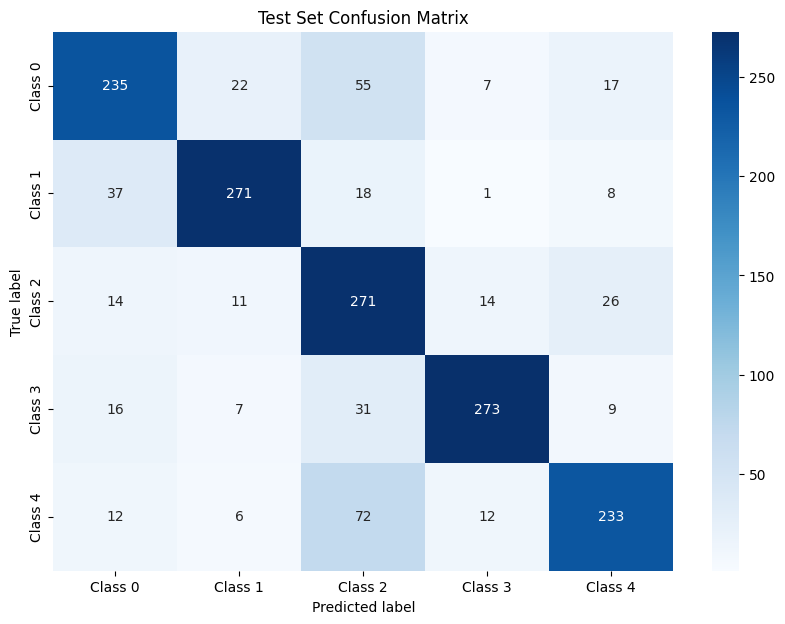

In [58]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Assuming your class names are available as a list
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with your actual class names

# Plotting confusion matrix for training set
plot_confusion_matrix(cm_train, classes=class_names, title='Training Set Confusion Matrix')

# Plotting confusion matrix for test set
plot_confusion_matrix(cm_test, classes=class_names, title='Test Set Confusion Matrix')


### AUC Score And ROC

In [59]:
# Get predicted probabilities for the test set
y_test_prob = model.predict(X_test)  # Shape: (num_samples, num_classes)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [60]:
# Initialize lists to hold false positive rates, true positive rates, and AUC values
fpr = {}
tpr = {}
roc_auc = {}

# Loop through each class
for i in range(y_test_onehot.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [61]:
# Initialize lists to hold false positive rates, true positive rates, and AUC values
fpr = {}
tpr = {}
roc_auc = {}

# Loop through each class
for i in range(y_test_onehot.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


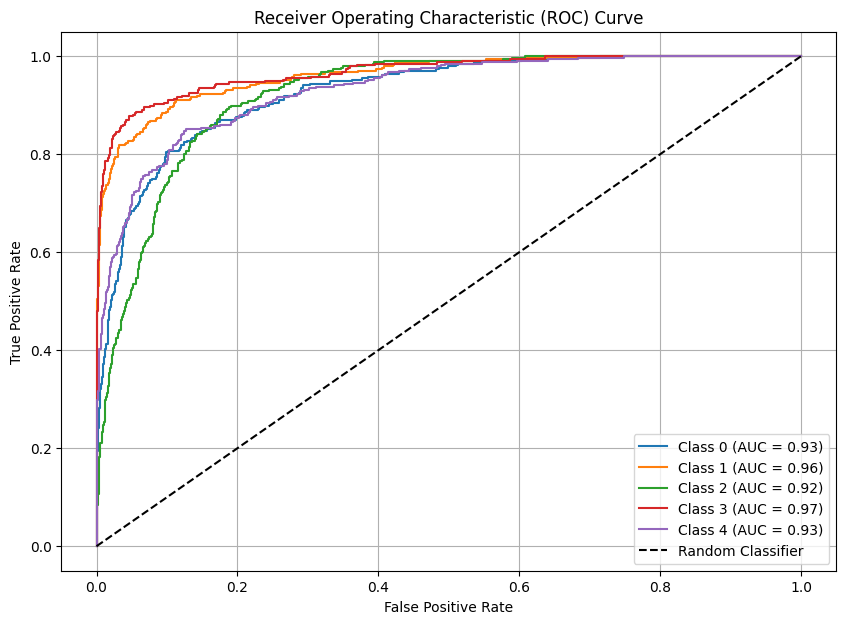

In [62]:
# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(y_test_onehot.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Unique values in y_test_true: [0 1 2 3 4]
### Unique values in y_test_pred_classes: [0 1 2 3 4]
# Classification Report: 

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       336
           1       0.85      0.81      0.83       335
           2       0.62      0.79      0.70       336
           3       0.88      0.85      0.86       336
           4       0.86      0.67      0.75       335

    accuracy                           0.78      1678
   macro avg       0.79      0.78      0.78      1678
weighted avg       0.79      0.78      0.78      1678



# Output Function 

In [63]:

# Save the trained model
model.save('CNN.h5')  # Save the model for later use


In [64]:
# Save the trained model in the Keras format
model.save('CNN.keras')  # Use the native Keras format


In [65]:
def predict_class(model_path, img_path, class_labels):
    """
    Predict the class of a given image.

    Parameters:
    - model_path: Path to the saved Keras model
    - img_path: Path to the image file
    - class_labels: List of class labels for mapping predictions

    Returns:
    - Predicted class and its probability
    """
    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(128, 128))  # Adjust size as needed
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]

    return predicted_class, predicted_probability


In [67]:
# Example usage
class_labels = ['drink', 'food', 'inside', 'menu', 'outside']  # Update with your actual class names
img_path = 'C:/Users/singh/Downloads/yelp_dataset/photos/__gAh0oU6R4XRgVVHI9E7Q.jpg'  # Replace with your image path
model_path = 'CNN.keras'  # Path to your saved model

predicted_class, predicted_probability = predict_class(model_path, img_path, class_labels)

print(f'Predicted class: {predicted_class}, Probability: {predicted_probability:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted class: outside, Probability: 0.68
